In [3]:
import music21
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# 2/4
score1 = music21.converter.parse('./asap-dataset/Mozart/Piano_Sonatas/11-3/xml_score.musicxml')
# 3/4
score2 = music21.converter.parse('./asap-dataset/Mozart/Piano_Sonatas/12-1/xml_score.musicxml')
# 4/4
score3 = music21.converter.parse('./asap-dataset/Mozart/Piano_Sonatas/12-2/xml_score.musicxml')

In [5]:
def parse_score_to_dataframe(score):
    rhythm_data_list = []
    for part_index, part in enumerate(score.parts):
        clefs = part.getElementsByClass('Clef')
        clef_name = clefs[0].sign if clefs else f"Part_{part_index+1}_NoClef"

        for measure in part.getElementsByClass('Measure'):
            time_signature = measure.timeSignature
            if time_signature:
                time_signature_str = f"{time_signature.numerator}/{time_signature.denominator}"
            else:
                time_signature_str = "NoTimeSignature"

            for event in measure.notesAndRests:
                label = "sounded" if isinstance(event, music21.note.Note) else "unsounded"
                tie_info = f"tie_{event.tie.type}" if event.tie else "no_tie"
                # compute onset
                global_onset = (measure.number - 1) * measure.barDuration.quarterLength + event.offset
                rhythm_data_list.append({
                    'staff': clef_name,
                    'measure_number': measure.number,
                    'time_signature': time_signature_str,
                    'event_type': label,
                    'onset_in_measure': event.offset,
                    'onset_in_score': global_onset,
                    'duration': event.duration.quarterLength,
                    'tie_info': tie_info
                })

    return pd.DataFrame(rhythm_data_list)

In [6]:
def extract_onset_in_measure(rhythm_data_list):
    columns_to_extract = ['onset_in_score', 'staff', 'duration', 'time_signature']
    onsets_df = rhythm_data_list[(rhythm_data_list['event_type'] == "sounded") & (rhythm_data_list['tie_info'] != "tie_stop")]['onset_in_measure']
    return onsets_df

In [7]:
# DataFrame
score1_df = parse_score_to_dataframe(score1)
score2_df = parse_score_to_dataframe(score2)
score3_df = parse_score_to_dataframe(score3)

# onsets
onsets_note_info1 = extract_onset_in_measure(score1_df).astype(float)
onsets_note_info2 = extract_onset_in_measure(score2_df).astype(float)
onsets_note_info3 = extract_onset_in_measure(score3_df).astype(float)

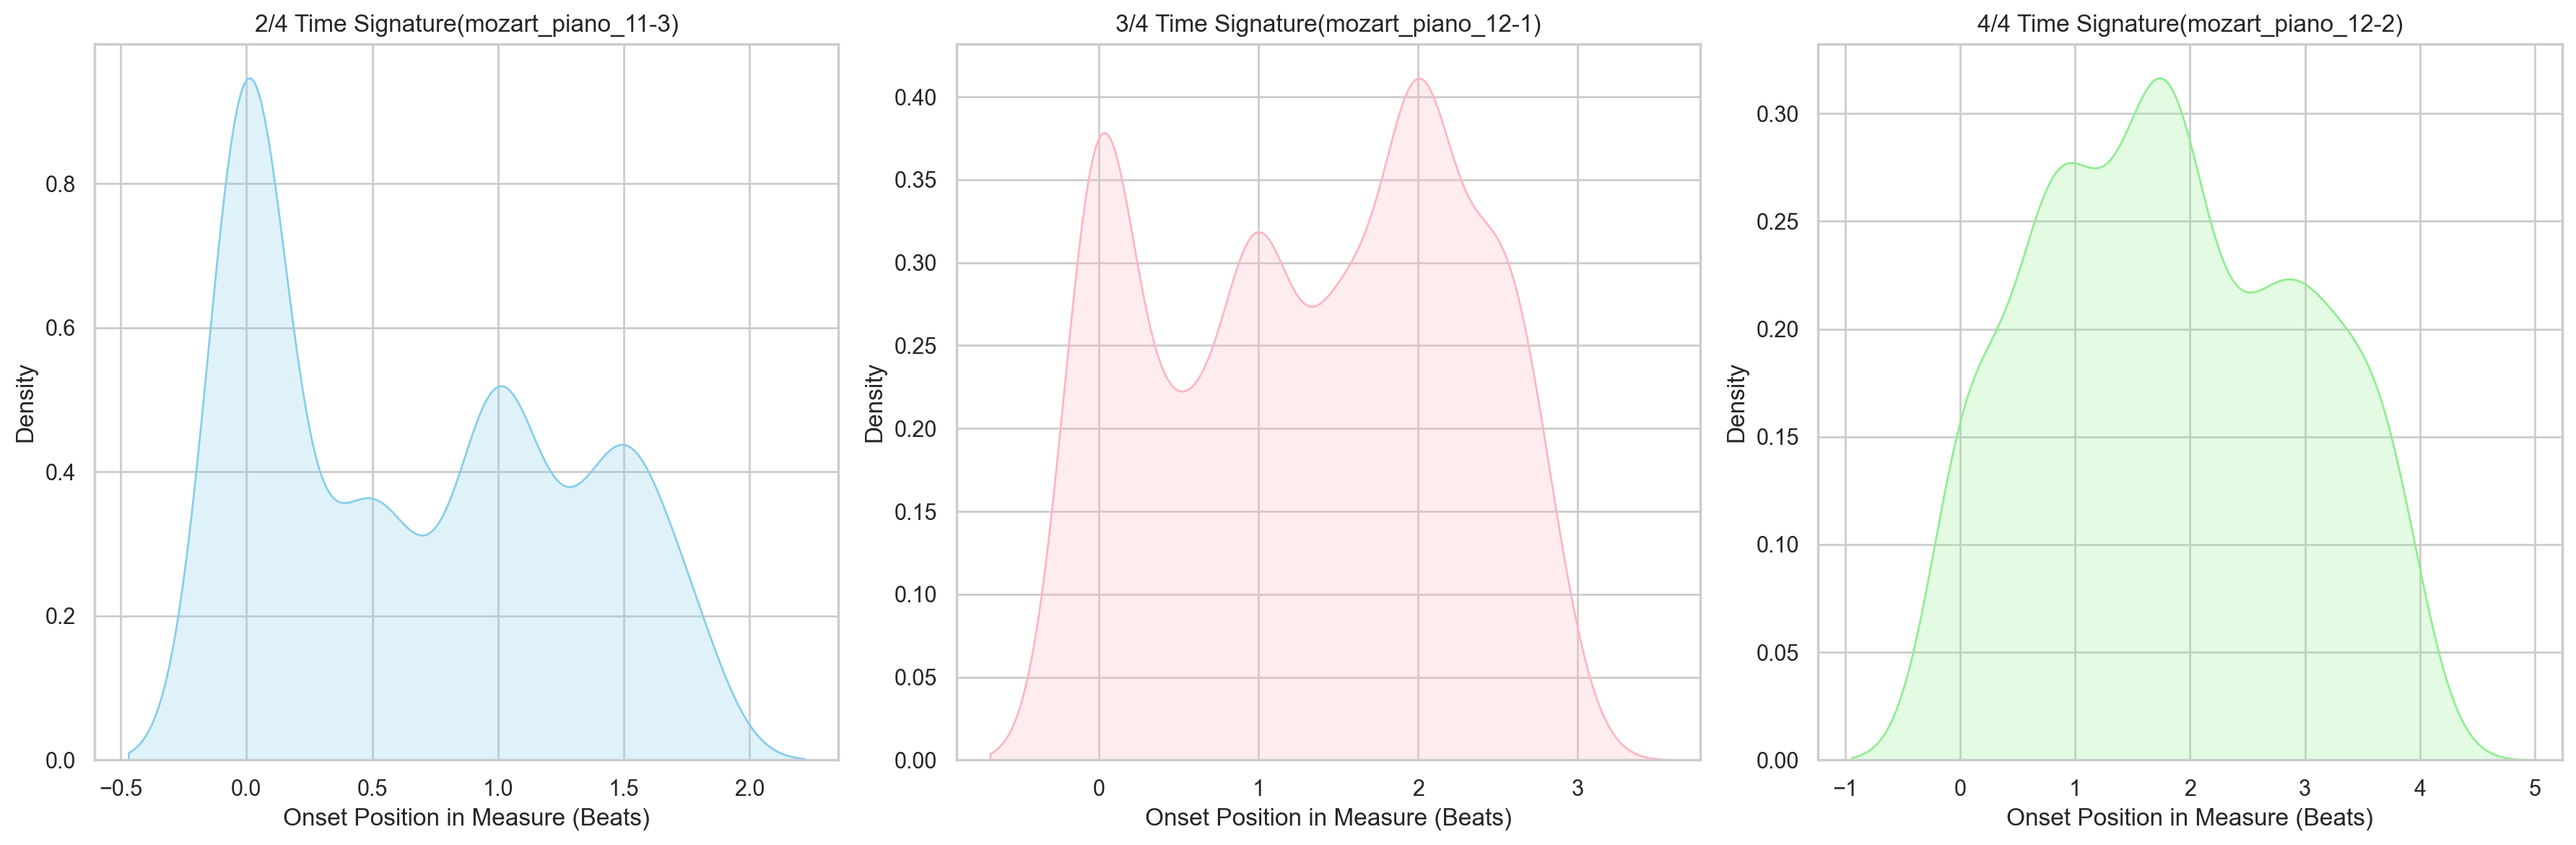

In [8]:
sns.set(style="whitegrid")
colors = ['skyblue', 'lightpink', 'lightgreen']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

titles = ['2/4 Time Signature(mozart_piano_11-3)', '3/4 Time Signature(mozart_piano_12-1)', '4/4 Time Signature(mozart_piano_12-2)']
onsets_note_infos = [onsets_note_info1, onsets_note_info2, onsets_note_info3]
time_signatures = [2, 3, 4]

for i, (onsets_note_info, ts) in enumerate(zip(onsets_note_infos, time_signatures)):
    sns.kdeplot(onsets_note_info, ax=axs[i], bw_adjust=1, fill=True, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Onset Position in Measure (Beats)')
    axs[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

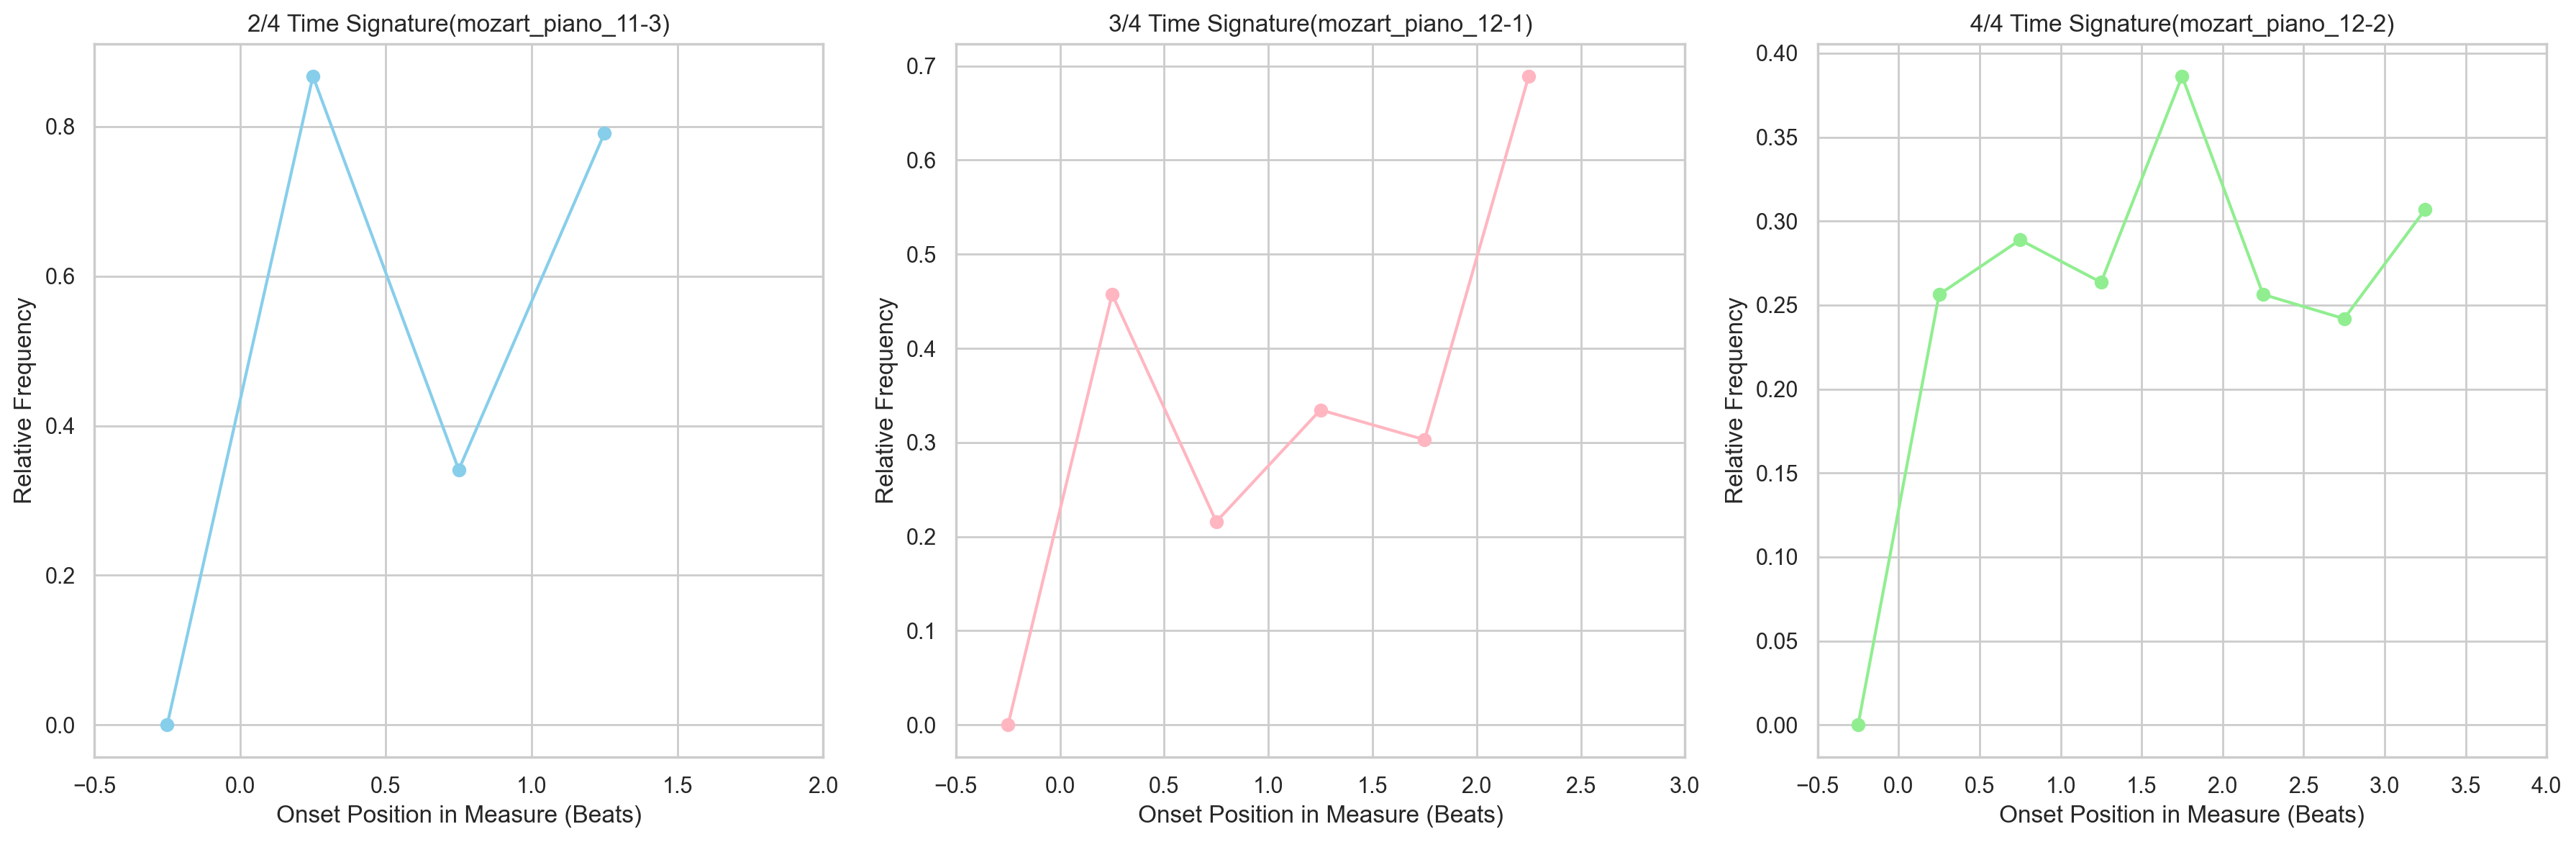

In [9]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

titles = ['2/4 Time Signature(mozart_piano_11-3)', '3/4 Time Signature(mozart_piano_12-1)', '4/4 Time Signature(mozart_piano_12-2)']
onsets_note_infos = [onsets_note_info1, onsets_note_info2, onsets_note_info3]
time_signatures = [2, 3, 4]

for i, (onsets_note_info, ts) in enumerate(zip(onsets_note_infos, time_signatures)):
    total_beats = ts

    frequencies, edges = np.histogram(onsets_note_info, bins=np.arange(-0.5, total_beats, 0.5), density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    axs[i].plot(centers, frequencies, marker='o', linestyle='-', color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlim(-0.5, total_beats)
    axs[i].set_xlabel('Onset Position in Measure (Beats)')
    axs[i].set_ylabel('Relative Frequency')

plt.tight_layout()
plt.show()

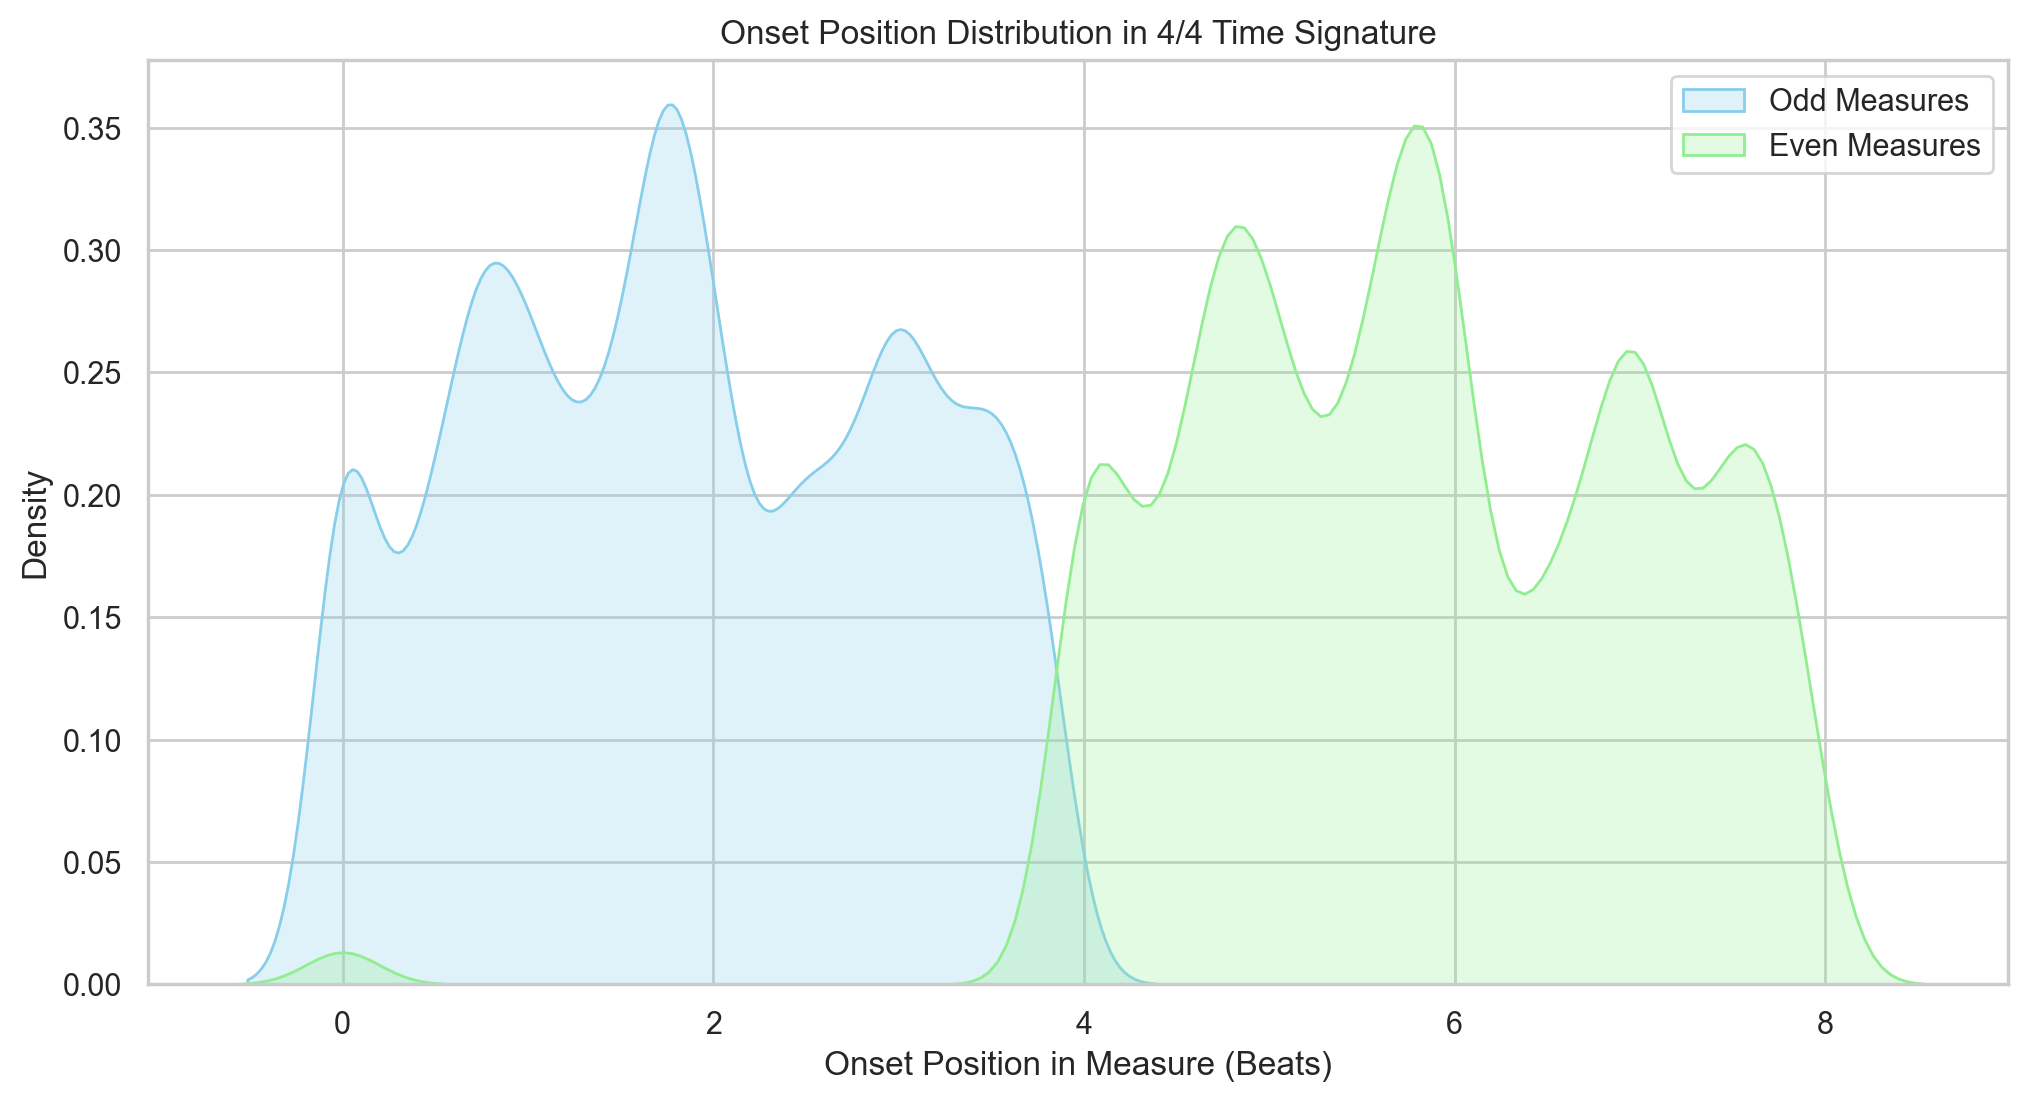

In [10]:
score3_df['onset_in_measure'] = pd.to_numeric(score3_df['onset_in_measure'], errors='coerce')
score3_df = score3_df.dropna(subset=['onset_in_measure'])

odd_measures_onsets = score3_df[score3_df['measure_number'] % 2 == 1]['onset_in_measure']
even_measures_onsets = score3_df[score3_df['measure_number'] % 2 == 0]['onset_in_measure'] + 4
even_measures_onsets = even_measures_onsets % 8


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(odd_measures_onsets, bw_adjust=0.5, fill=True, color='skyblue', label='Odd Measures', ax=ax)
sns.kdeplot(even_measures_onsets, bw_adjust=0.5, fill=True, color='lightgreen', label='Even Measures', ax=ax)
ax.set_title('Onset Position Distribution in 4/4 Time Signature')
ax.set_xlabel('Onset Position in Measure (Beats)')
ax.set_ylabel('Density')
ax.legend()

plt.show()